In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np

from experiments.dataset import Focus

In [2]:
pretrained_model = models.resnet50(pretrained=True)
pretrained_model.cuda()
pretrained_model.eval()
finetuned_model = models.resnet50()
ckpt = torch.load("../../logs/regularized_finetuning/ckpt.pth")
finetuned_model.load_state_dict(ckpt["model_state_dict"])
finetuned_model.cuda()
finetuned_model.eval()
locations = list(Focus.locations.keys())
location_classifiers = []
for location in locations:
    location_classifiers.append(torch.load(f"{location}.pth"))

In [3]:
with torch.no_grad():
    for lc in location_classifiers:
        print(torch.max((pretrained_model.fc.weight @ lc.weight.T) ** 2).item(), torch.min((pretrained_model.fc.weight @ lc.weight.T) ** 2).item())
    print("--------------")
    for lc in location_classifiers:
        print(torch.max((finetuned_model.fc.weight @ lc.weight.T) ** 2).item())

0.16228412091732025 2.675928811868289e-09
0.3417190909385681 3.699641482057814e-09
0.443753719329834 1.3580036011262564e-06
0.22923457622528076 1.430132954283181e-07
0.3424852192401886 5.778777900644627e-09
0.23380321264266968 3.90202252731342e-08
0.9886645078659058 1.3092633821543131e-07
0.3959638774394989 3.571212658926015e-08
0.14375926554203033 2.9544416912941074e-10
--------------
0.0002404011320322752
0.000193880929145962
0.0006449113134294748
0.0013971776934340596
0.0010270739439874887
0.000308412651065737
0.0028377901762723923
0.0010075533064082265
0.09744621813297272


In [4]:
pre_pred = np.load("../../logs/resnet/predictions.npy")
fine_pred = np.load("../../logs/regularized_finetuning/predictions.npy")
print(pre_pred.shape, fine_pred.shape)

(20815, 15) (20815, 15)


In [5]:
test_transform = T.Compose(
    [
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
bg_var_root = Path("/cmlscratch/pkattaki/datasets/focus")
categories = list(Focus.categories.keys())
locations = list(Focus.locations.keys())
dataset = Focus(
    bg_var_root,
    categories=categories,
    times=None,
    weathers=None,
    locations=None,
    transform=None,
)

In [6]:
comparison = {
    "pre_correct": [],
    "fine_correct": [],
    "both_correct": [],
    "both_wrong": [],
}
for i in range(pre_pred.shape[0]):
    if pre_pred[i, 14] == 1:
        if fine_pred[i, 14] == 1:
            comparison["both_correct"].append(i)
        else:
            comparison["pre_correct"].append(i)
    else:
        if fine_pred[i, 14] == 1:
            comparison["fine_correct"].append(i)
        else:
            comparison["both_wrong"].append(i)

In [7]:
for k in comparison:
    print(f"{k}: {len(comparison[k])}")
    

pre_correct: 219
fine_correct: 408
both_correct: 17126
both_wrong: 3062


In [8]:
with open("./imagenet_idx_to_labels.txt") as f:
    idx_to_labels = eval(f.read())

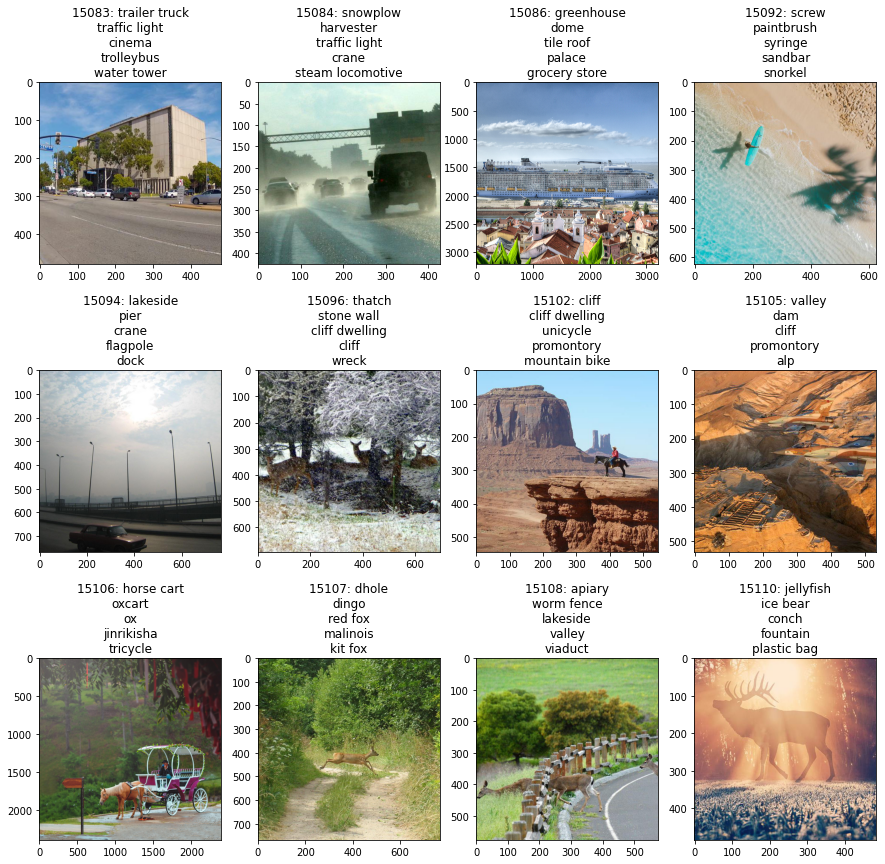

In [9]:
_, ax = plt.subplots(3, 4, figsize=(15, 15))
start = 1000
nl = "\n"
with torch.no_grad():
    for n, idx in enumerate(comparison["both_wrong"][start:start + 12]):
        image, category, _, _, _ = dataset[idx]
        output = pretrained_model(test_transform(image).unsqueeze(0).cuda()).squeeze()
        predictions = torch.sort(output, descending=True)[1][:5]
        labels = [idx_to_labels[prediction.cpu().item()] for prediction in predictions]
        ax[n // 4, n % 4].imshow(image)
        ax[n // 4, n % 4].set_title(f"{idx}: {nl.join([label.split(',')[0] for label in labels])}")

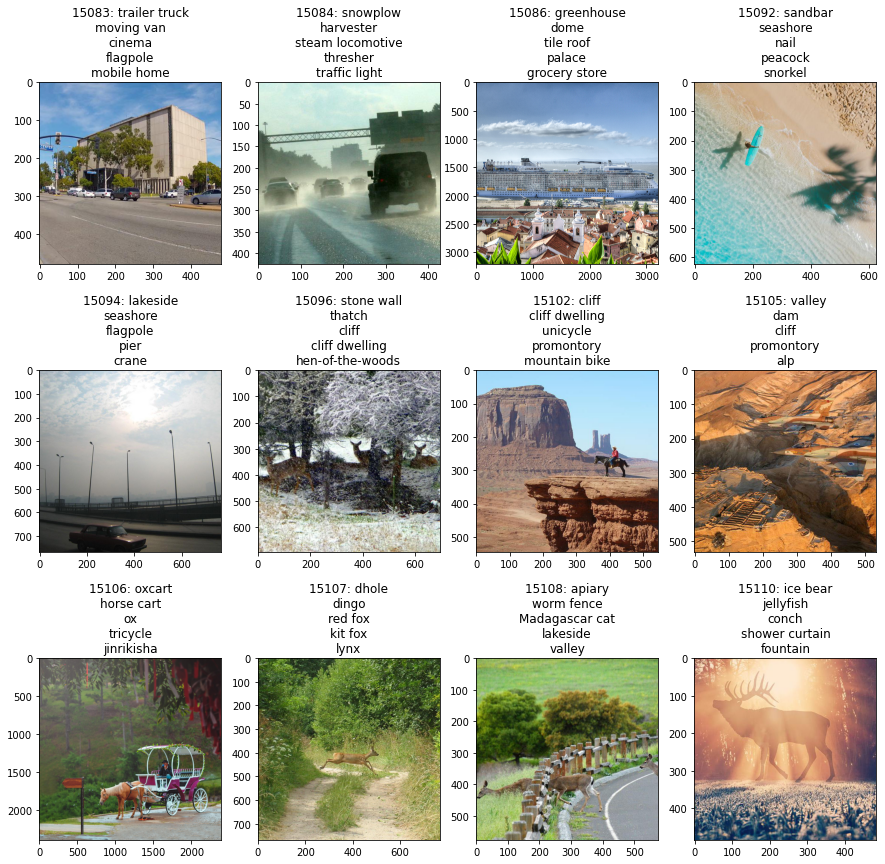

In [10]:
_, ax = plt.subplots(3, 4, figsize=(15, 15))
start = 1000
nl = "\n"
with torch.no_grad():
    for n, idx in enumerate(comparison["both_wrong"][start:start + 12]):
        image, category, _, _, _ = dataset[idx]
        output = finetuned_model(test_transform(image).unsqueeze(0).cuda()).squeeze()
        predictions = torch.sort(output, descending=True)[1][:5]
        labels = [idx_to_labels[prediction.cpu().item()] for prediction in predictions]
        ax[n // 4, n % 4].imshow(image)
        ax[n // 4, n % 4].set_title(f"{idx}: {nl.join([label.split(',')[0] for label in labels])}")

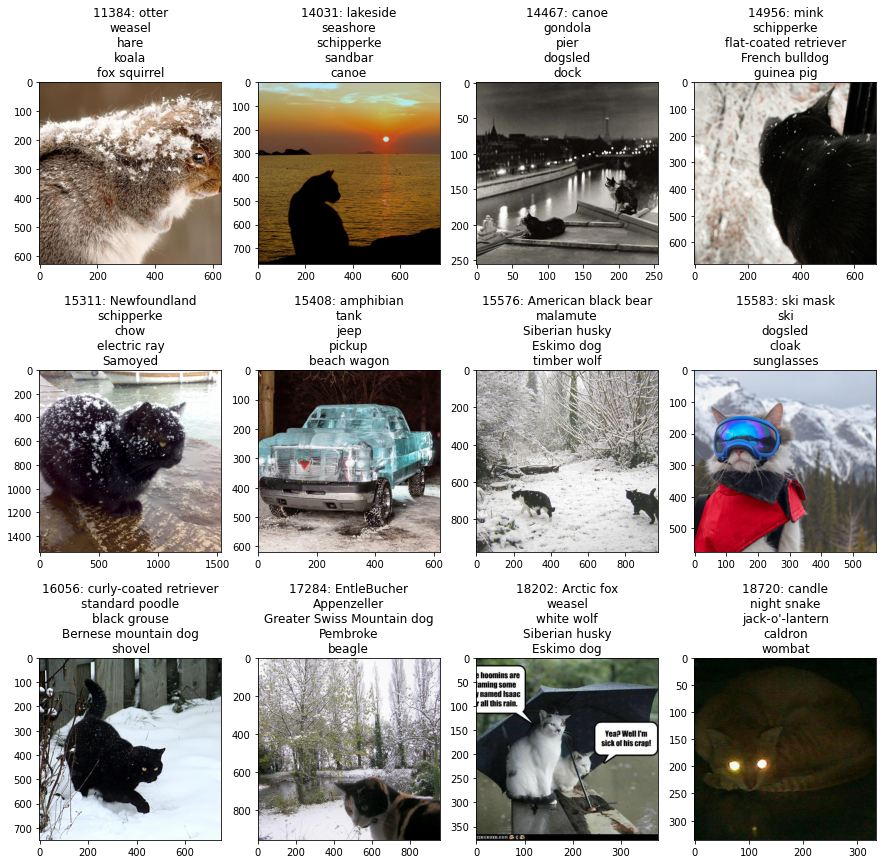

In [11]:
_, ax = plt.subplots(3, 4, figsize=(15, 15))
n = 0
with torch.no_grad():
    for idx in range(pre_pred.shape[0]):
        if pre_pred[idx, 4] == 1 and pre_pred[idx, 14] == 0 and sum(pre_pred[idx, 10:13]) >= 2:
            image, category, _, _, _ = dataset[idx]
            output = pretrained_model(test_transform(image).unsqueeze(0).cuda()).squeeze()
            predictions = torch.sort(output, descending=True)[1][:5]
            labels = [idx_to_labels[prediction.cpu().item()] for prediction in predictions]
            ax[n // 4, n % 4].imshow(image)
            ax[n // 4, n % 4].set_title(f"{idx}: {nl.join([label.split(',')[0] for label in labels])}")
            n += 1
        if n >= 12:
            break

In [13]:
dataset.image_files[18720]

('/cat-night/86.jpeg', 'cat', 'night', 'none', 'water')